In [1]:
import sys
import re
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Read all files

In [2]:
tk = th.Thicket.from_caliperreader(glob("caliFiles3/*.cali"))

(2/2) Creating Thicket: 100%|██████████| 279/279 [00:07<00:00, 39.84it/s]


View Calltree

In [3]:
print(tk.tree(metric_column="Avg time/rank"))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

2.316 main
├─ 0.452 comm
│  └─ 0.452 comm_large
├─ 0.347 comp
│  └─ 0.347 comp_large
├─ 0.001 correctness_check
└─ 0.014 data_init_runtime

Legend (Metric: Avg time/rank Min: 0.00 Max: 2.32 indices: {'profile': 1043000})
█ 2.08 - 2.32
█ 1.62 - 2.08
█ 1.16 - 1.62
█ 0.70 - 1.16
█ 0.23 - 0.70
█ 0.00 - 0.23

name User code    ◀  Only in left graph    ▶  Only in right graph



Group Performance data by `matrix_size` in the Thicket metadata table.

In [4]:
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [5]:
def plot_mpl(df, title, xlabel, col):
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1, 1, 1)
    
    labels = df['input_type'].unique()
    for label in labels:
        subset = df[df['input_type'] == label]  # Filter data by array_type
        subset = subset.sort_values(by='num_procs')
        ax.plot(subset['num_procs'], subset[col], marker='o', label=label+' '+col[0:3])

        
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(col)
    ax.legend()
    plt.xscale("log", base=2)
    plt.xticks(processes)
    ax.set_xticklabels(processes)
    plt.show()
    return fig, ax

In [6]:
node_indices = tk.get_node("main")
print(node_indices)  # Inspect what this returns
print(tk.metadata.columns)

{'name': 'main', 'type': 'function'}
Index(['cali.caliper.version', 'mpi.world.size', 'spot.metrics',
       'spot.timeseries.metrics', 'spot.format.version', 'spot.options',
       'spot.channels', 'cali.channel', 'spot:node.order', 'spot:output',
       'spot:region.count', 'spot:time.exclusive', 'launchdate', 'libraries',
       'cmdline', 'cluster', 'algorithm', 'programming_model', 'data_type',
       'size_of_data_type', 'input_size', 'input_type', 'num_procs',
       'scalability', 'group_num', 'implementation_source'],
      dtype='object')


In [7]:
input_size_filter = tk.metadata['input_size'] == 65536

# Use the filter to get relevant data
array_types = tk.metadata.loc[input_size_filter, "input_type"]
num_procs = tk.metadata.loc[input_size_filter, 'num_procs'] + 1

In [8]:
main_time = tk.dataframe.loc[tk.get_node("main"), ["Min time/rank","Max time/rank","Avg time/rank", "Total time"]]
# print(main_time)
main_time = pd.merge(main_time, array_types, on="profile").merge(num_procs, on="profile")
variance = ((main_time['Max time/rank'] - main_time['Avg time/rank'])**2 + 
                            (main_time['Min time/rank'] - main_time['Avg time/rank'])**2) / 2

variance_main_time = pd.DataFrame({
    'input_type': main_time['input_type'], 
    'num_procs': main_time['num_procs'],
    'Variance time/rank': variance
})

In [9]:
nodes = tk.dataframe.loc[tk.get_node("main")]
nodes.shape

(280, 15)

In [10]:
def plot_all(df_section, title):

    plot_mpl(
        df=df_section,
        title=f"Min {title} for 2^28 array size",
        xlabel="num_procs",
        col="Min time/rank"
    )
    plot_mpl(
        df=df_section,
        title=f"Avg {title} for 2^28 array size",
        xlabel="num_procs",
        col="Avg time/rank"
    )
    plot_mpl(
        df=df_section,
        title=f"Max {title} for 2^28 array size",
        xlabel="num_procs",
        col="Max time/rank"
    )

In [11]:
comm_time = tk.dataframe.loc[tk.get_node("comp_large"), ["Min time/rank","Max time/rank","Avg time/rank", "Total time"]]
# print(main_time)
comm_time = pd.merge(comm_time, array_types, on="profile").merge(num_procs, on="profile")

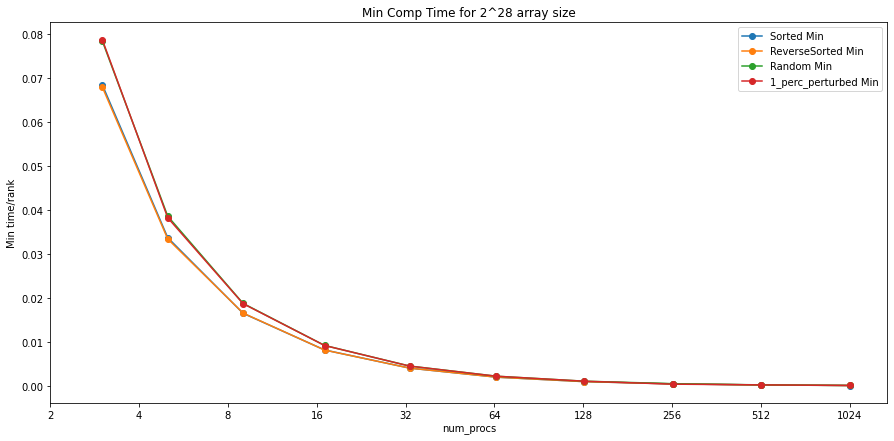

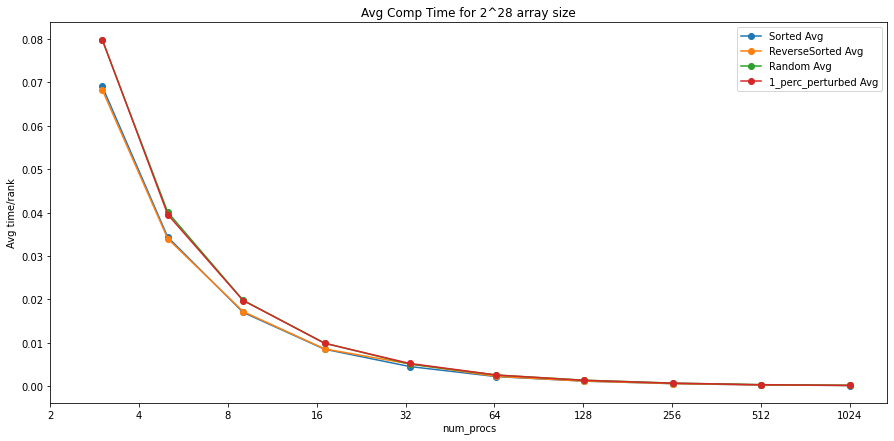

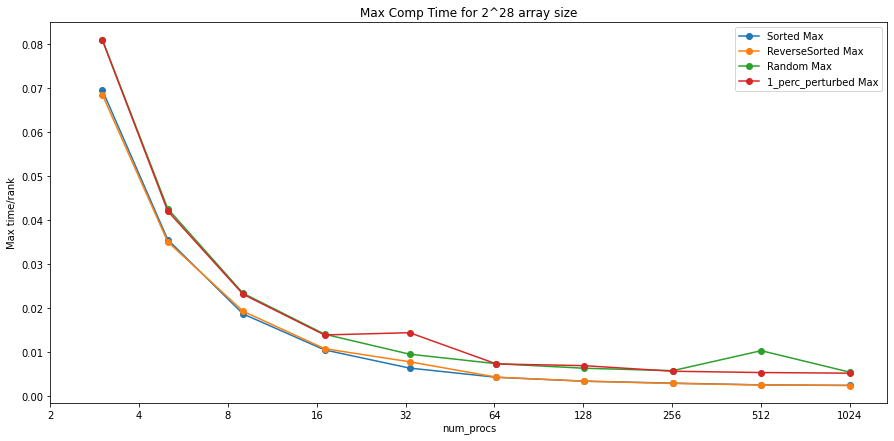

In [12]:
plot_all(comm_time, 'Comp Time')

In [13]:
def plot(df, sz):
    input_size_filter = tk.metadata['input_size'] == 268435456
    # Use the filter to get relevant data
    main_time = df.dataframe.loc[df.get_node("main"), ["Max time/rank"]]
    array_types = df.metadata.loc[input_size_filter, "input_type"]
    num_procs = tk.metadata.loc[input_size_filter, 'num_procs']
    main_time = pd.merge(main_time, array_types, on="profile").merge(num_procs, on="profile")
    # main_time.sort_values(by='num_procs').tail(20)
    plot_mpl(
        df=main_time,
        title=f"Total Main Time for 2^{sz} array size",
        xlabel="num_procs",
        col="Max time/rank"
    )
    
    comm_time = df.dataframe.loc[df.get_node("comm_large"), ["Avg time/rank"]]
    comm_time = pd.merge(comm_time, array_types, on="profile").merge(num_procs, on="profile")

    plot_mpl(
        df=comm_time,
        title=f"Avg Comm Time for 2^{sz} array size",
        xlabel="num_procs",
        col="Avg time/rank"
    )

    comp_time = df.dataframe.loc[df.get_node("comp_large"), ["Avg time/rank"]]
    comp_time = pd.merge(comp_time, array_types, on="profile").merge(num_procs, on="profile")

    plot_mpl(
        df=comp_time,
        title=f"Avg Comp Time for 2^{sz} array size",
        xlabel="num_procs",
        col="Avg time/rank"
    )

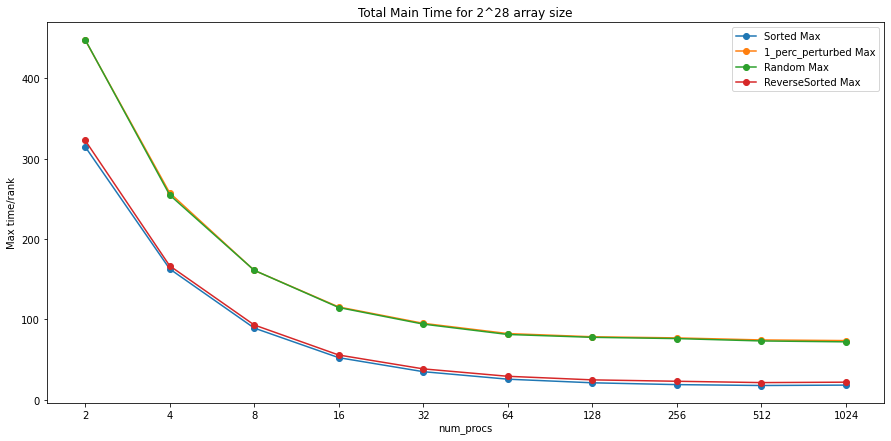

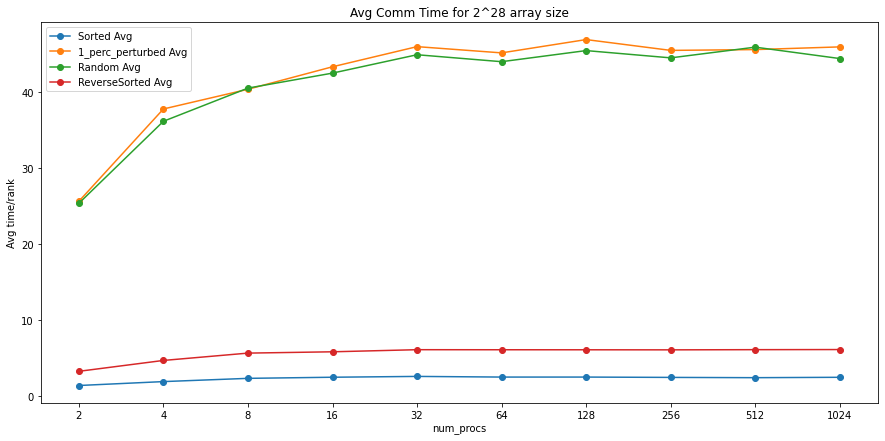

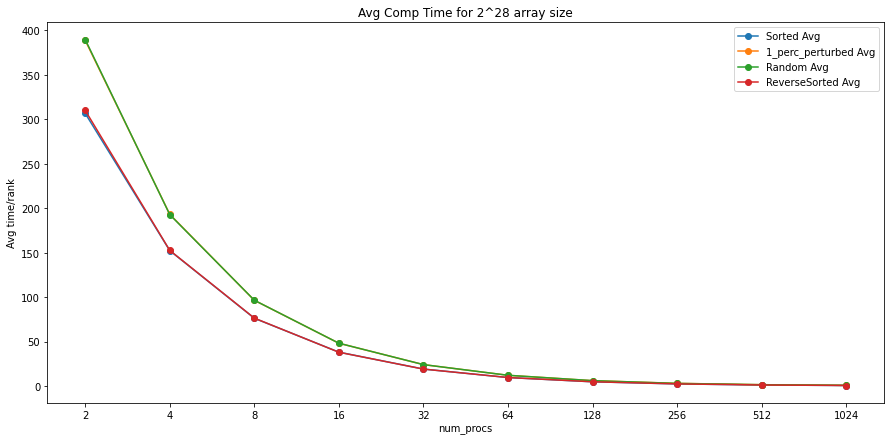

In [14]:
plot(tk, 28)

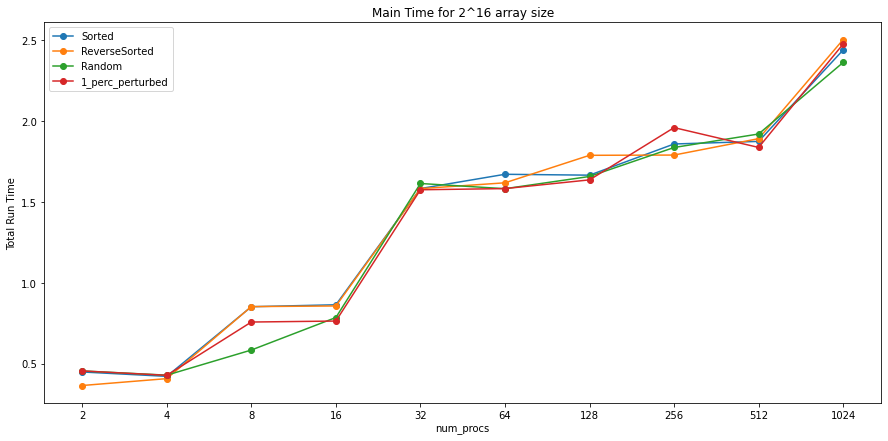

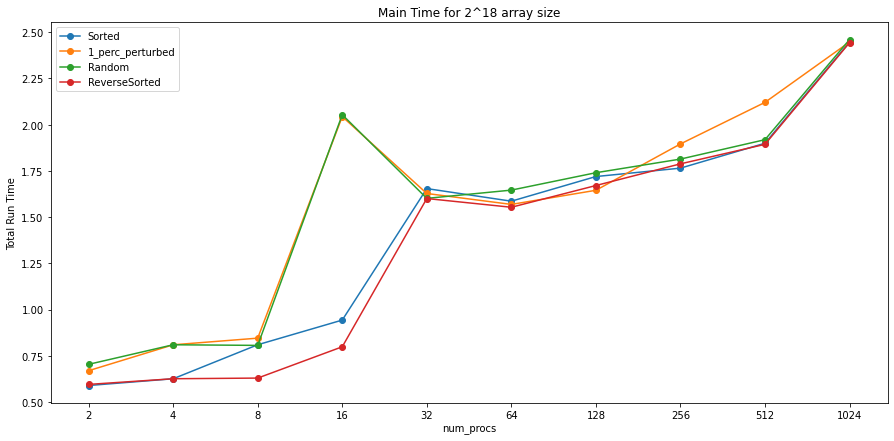

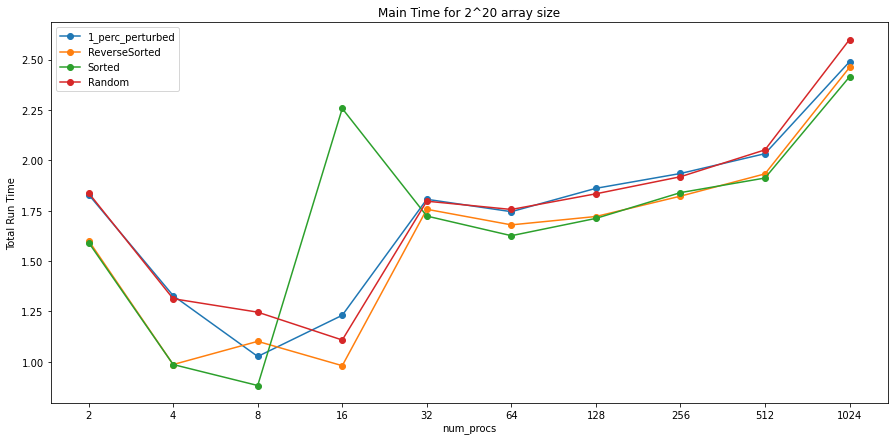

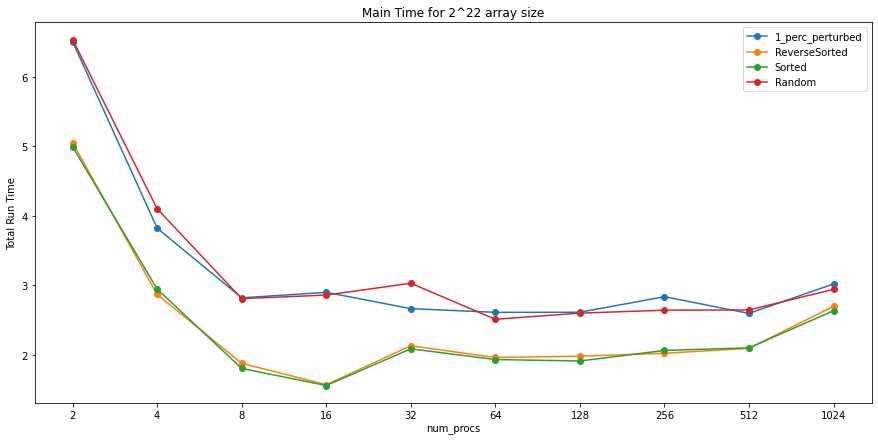

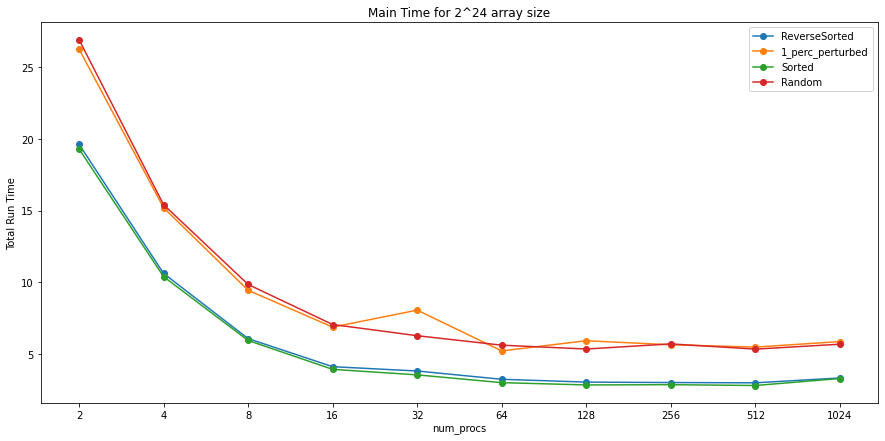

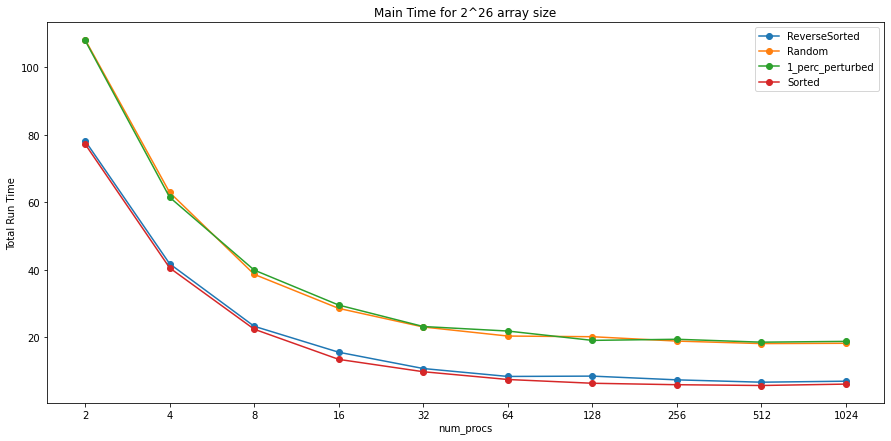

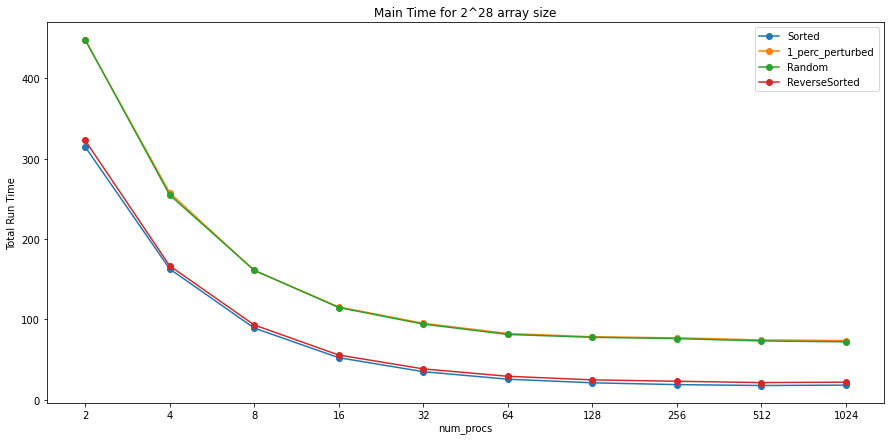

In [15]:
# all strong scaling main graphs
size_labels = ['2^16', '2^18', '2^20', '2^22', '2^24', '2^26', '2^28']
sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]

for i in range(7):
    input_size_filter = tk.metadata['input_size'] == sizes[i]
    # Use the filter to get relevant data
    main_time = tk.dataframe.loc[tk.get_node("main"), ["Max time/rank"]]
    array_types = tk.metadata.loc[input_size_filter, "input_type"]
    num_procs = tk.metadata.loc[input_size_filter, 'num_procs']
    main_time = pd.merge(main_time, array_types, on="profile").merge(num_procs, on="profile")
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1, 1, 1)
    
    labels = main_time['input_type'].unique()
    for label in labels:
        subset = main_time[main_time['input_type'] == label]  # Filter data by array_type
        subset = subset.sort_values(by='num_procs')
        ax.plot(subset['num_procs'], subset["Max time/rank"], marker='o', label=label)

        
    ax.set_title(f'Main Time for {size_labels[i]} array size')
    ax.set_xlabel('num_procs')
    ax.set_ylabel("Total Run Time")
    ax.legend()
    plt.xscale("log", base=2)
    plt.xticks(processes)
    ax.set_xticklabels(processes)
    plt.show()

{'Random': [0.452283, 0.796426, 1.168922, 2.53686, 4.907232, 14.698149, 53.565549], 'Sorted': [0.446617, 0.618782, 0.842711, 1.384685, 2.827347, 4.553132, 9.007439], '1_perc_perturbed': [0.452575, 0.796218, 0.954819, 2.570845, 5.176798, 16.176743, 54.9925], 'ReverseSorted': [0.362011, 0.618793, 1.062013, 1.397579, 3.102071, 5.484379, 12.642745]}


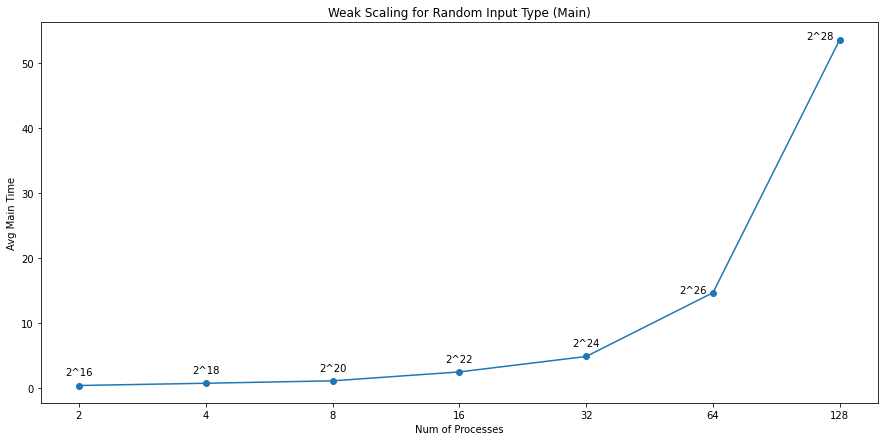

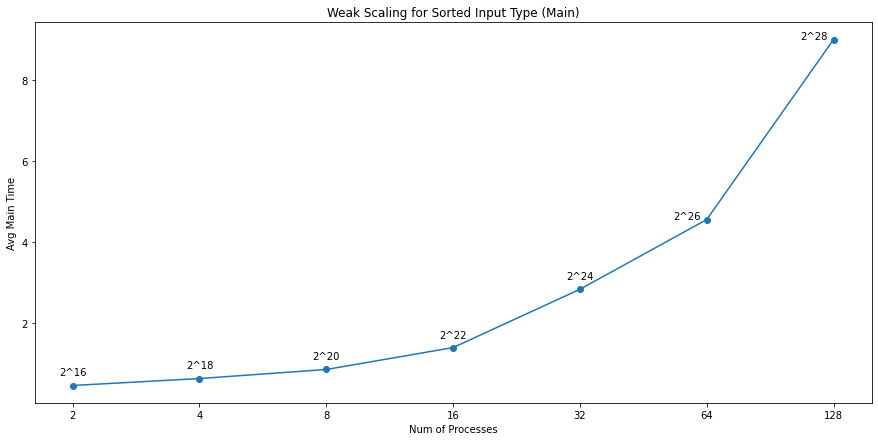

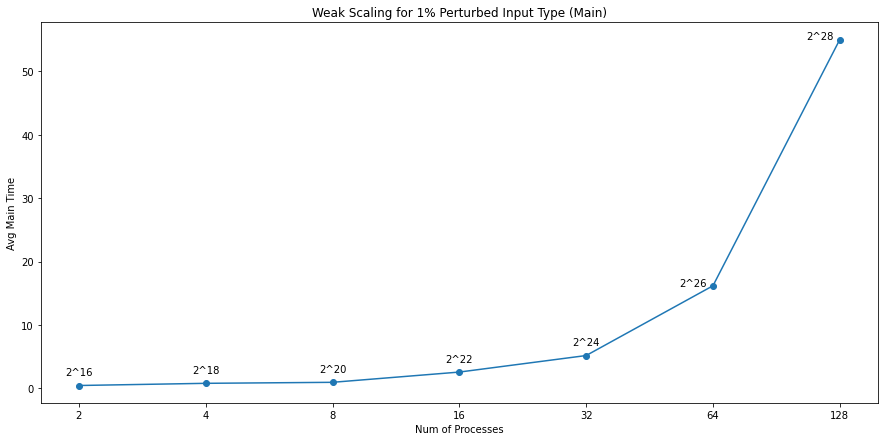

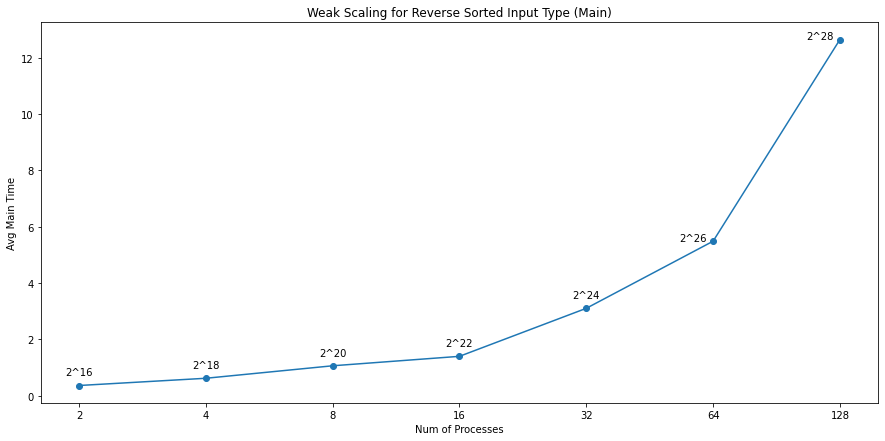

In [16]:
input_types = ['Random', 'Sorted', '1_perc_perturbed', 'ReverseSorted']
plt_names = ['Random', 'Sorted', '1% Perturbed', 'Reverse Sorted']
times = {label : [] for label in input_types}
sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
size_labels = ['2^16', '2^18', '2^20', '2^22', '2^24', '2^26', '2^28']

for i in range(7):
    input_size_filter = tk.metadata['input_size'] == sizes[i]
    # Use the filter to get relevant data
    main_time = tk.dataframe.loc[tk.get_node("main"), ["Avg time/rank"]]
    array_types = tk.metadata.loc[input_size_filter, "input_type"]
    num_procs = tk.metadata.loc[input_size_filter, 'num_procs']
    main_time = pd.merge(main_time, array_types, on="profile").merge(num_procs, on="profile")
    main_time.head()

    labels = main_time['input_type'].unique()
    for label in labels:
        subset = main_time[main_time['input_type'] == label]  # Filter data by array_type
        subset = subset.sort_values(by='num_procs')
        times[label].append(subset.loc[subset['num_procs'] == processes[i], 'Avg time/rank'].values[0])
        

print(times)
curr = 0
for label in input_types:
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(processes[0:7], times[label], marker='o')
    for i, txt in enumerate(size_labels):
        if i < 5:
            x = 0
            y = 10
        else:
            x = -20
            y = 0
        ax.annotate(txt, (processes[i], times[label][i]), textcoords="offset points", 
                    xytext=(x,y), ha='center')
    ax.set_title(f'Weak Scaling for {plt_names[curr]} Input Type (Main)')
    ax.set_xlabel('Num of Processes')
    ax.set_ylabel('Avg Main Time')
    plt.xscale("log", base=2)
    plt.xticks(processes[0:7])
    ax.set_xticklabels(processes[0:7])
    plt.show()
    curr += 1

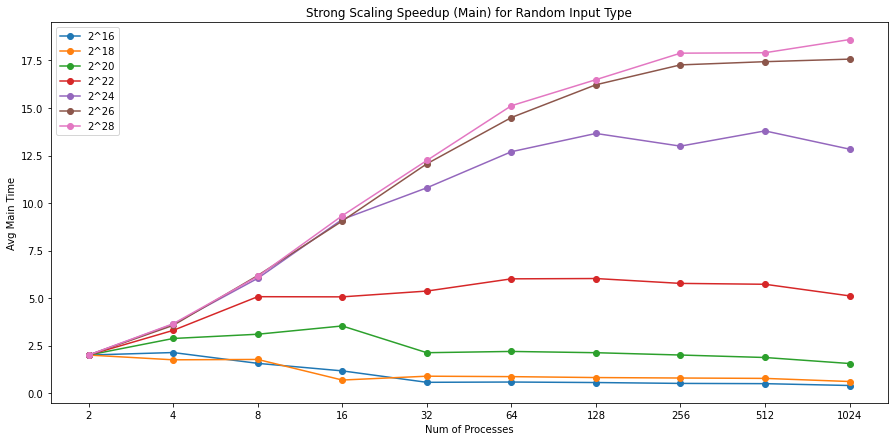

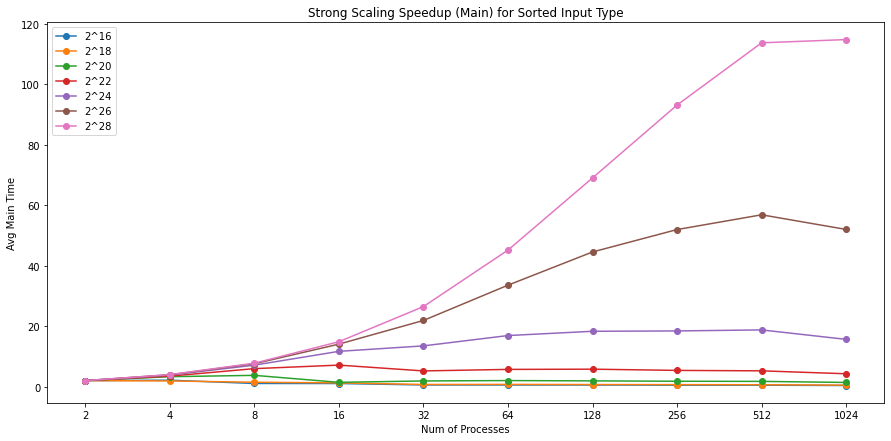

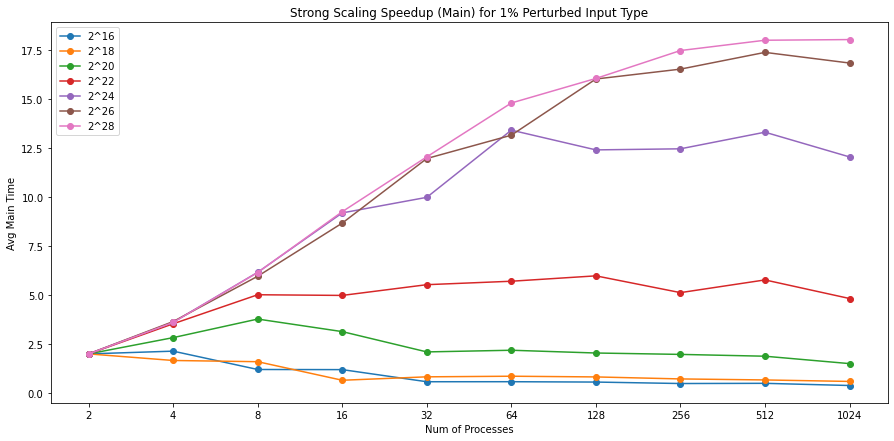

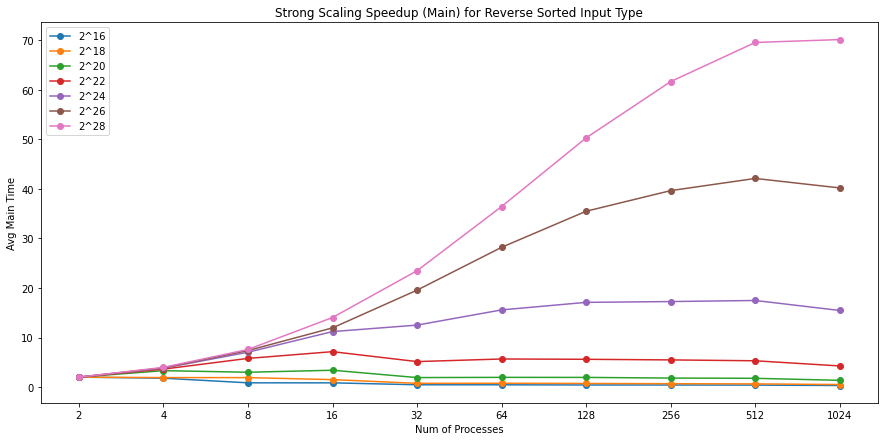

In [17]:
plt_names = ['Random', 'Sorted', '1% Perturbed', 'Reverse Sorted']
sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
size_labels = ['2^16', '2^18', '2^20', '2^22', '2^24', '2^26', '2^28']
times = {label : {sz : [] for sz in size_labels} for label in input_types}

for i in range(7):
    input_size_filter = tk.metadata['input_size'] == sizes[i]
    # Use the filter to get relevant data
    main_time = tk.dataframe.loc[tk.get_node("main"), ["Avg time/rank"]]
    array_types = tk.metadata.loc[input_size_filter, "input_type"]
    num_procs = tk.metadata.loc[input_size_filter, 'num_procs']
    main_time = pd.merge(main_time, array_types, on="profile").merge(num_procs, on="profile")

    labels = main_time['input_type'].unique()
    for label in labels:
        subset = main_time[main_time['input_type'] == label]  # Filter data by array_type
        subset = subset.sort_values(by='num_procs')
        subset_times = (2 * subset['Avg time/rank'].values[0]) / subset['Avg time/rank'].values
        
        times[label][size_labels[i]] = subset_times.tolist() 

# print(times)
curr = 0
for label in input_types:
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1, 1, 1)
    for sz in size_labels:
        ax.plot(processes, times[label][sz], marker='o', label=sz)
    ax.set_title(f'Strong Scaling Speedup (Main) for {plt_names[curr]} Input Type')
    ax.set_xlabel('Num of Processes')
    ax.set_ylabel('Avg Main Time')
    ax.legend()
    plt.xscale("log", base=2)
    plt.xticks(processes)
    ax.set_xticklabels(processes)
    plt.show()
    curr += 1

In [18]:
tkcm = th.Thicket.from_caliperreader(glob("missCaliFiles/*.cali"))

(2/2) Creating Thicket: 100%|██████████| 11/11 [00:00<00:00, 24.67it/s]


(12,)
(12,)


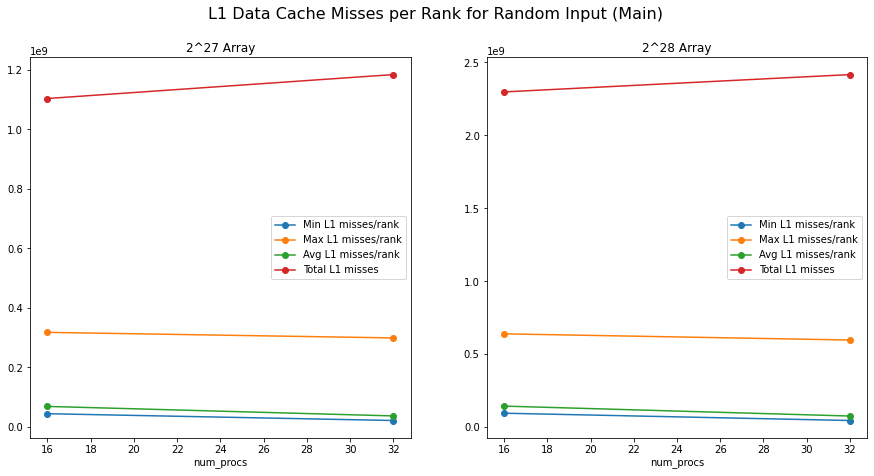

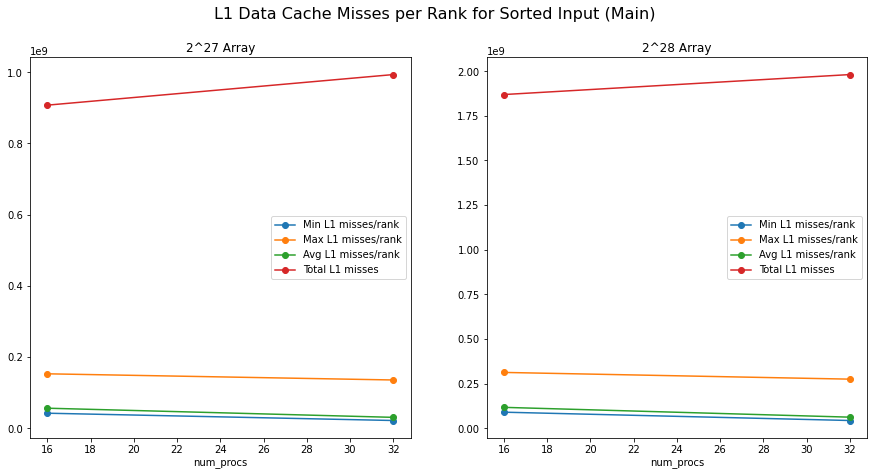

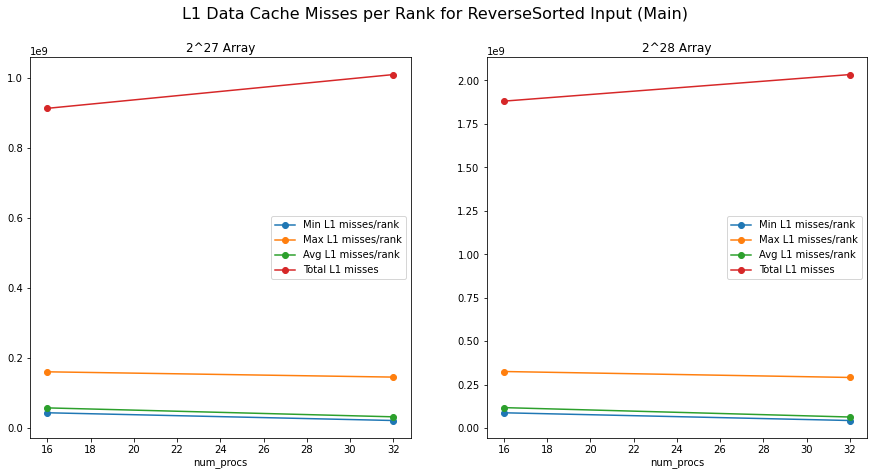

In [28]:
linesL1 = ["Min L1 misses/rank","Max L1 misses/rank", "Avg L1 misses/rank","Total L1 misses"]
linesL2 = ["Min L2 misses/rank","Max L2 misses/rank", "Avg L2 misses/rank","Total L2 misses"]
input_types = ['Random', 'Sorted', 'ReverseSorted']


mpi_world_size = tkcm.metadata['mpi.world.size']
input_sizes = tkcm.metadata["input_size"]
array_types = tkcm.metadata["input_type"]

print(mpi_world_size.shape)
print(input_sizes.shape)
main_time = tkcm.dataframe.loc[tkcm.get_node("main"), linesL1]
main_time = pd.merge(main_time, input_sizes, on="profile").merge(mpi_world_size, on="profile").merge(array_types, on ="profile")

for type in input_types:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    subset = main_time[main_time['input_size'] == 134217728]
    subset = subset[subset['input_type'] == type]
    for line in linesL1:
        ax1.plot(subset['mpi.world.size'], subset[line], marker='o', label=line)

    ax1.set_title(f'2^27 Array')
    ax1.set_xlabel('num_procs')
    ax1.legend()
    
    
    subset = main_time[main_time['input_size'] == 268435456]
    subset = subset[subset['input_type'] == type]

    for line in linesL1:
        ax2.plot(subset['mpi.world.size'], subset[line], marker='o', label=line)

    ax2.set_title(f'2^28 Array')
    ax2.set_xlabel('num_procs')
    ax2.legend()
    fig.suptitle(f'L1 Data Cache Misses per Rank for {type} Input (Main)', fontsize=16)

    plt.show()